**Using LSTMs to predict the product category.**

In [4]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [5]:
pip freeze > requirements.txt # generating the requirement.txt file

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Reading the cleaned version of the dataset that can be found [here](https://drive.google.com/file/d/1uM5Kr_CieByJkZiSxVeKPhSpWV-aUYTY/view?usp=sharing)

In [47]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flipkart_ecommerce_processed_sample.csv', index_col = 0)

print("The data shape is:", df.shape)
df.head()

The data shape is: (19287, 4)


,product_name,brand,description,label
0,U. R. GOD Business / Visiting 10 Card Holder,U. R. GOD,key features of u r god business visiting 10 ...,"Bags, Wallets & Belts"
1,Dong Yang 880 Pouch Soccer Art Cloth Pencil Box,NaN,flipkart com buy dong yang 880 pouch soccer ar...,Toys & School Supplies
2,Shreya Collection 3 Multicolour Hair Clips Ban...,Shreya Collection,key features of shreya collection 3 multicolou...,Beauty and Personal Care
3,Jewel Paradise Brass Plated Brass Necklace,Jewel Paradise,jewel paradise brass plated brass necklace bu...,Jewellery
4,Disney Princess Cartoon Art Plastic Pencil Box,NaN,flipkart com buy disney princess cartoon art p...,Toys & School Supplies


Let's take a look at the different categories in the dataset

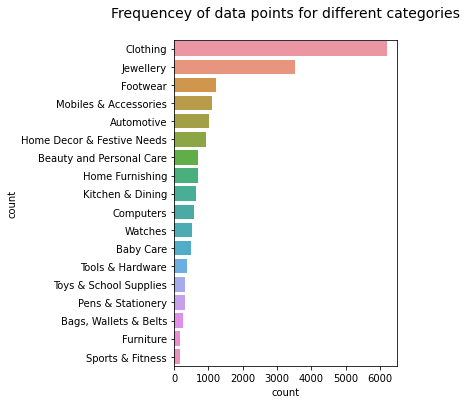


Total number of categories in the dataset -  18


In [48]:
value_counts = df.label.value_counts() # distinct categories in the dataset

all_categories = value_counts.to_frame('count')
all_categories['label'] = all_categories.index
all_categories = all_categories.reset_index(drop = True)

g = all_categories.nlargest(columns="count", n = 50) 
plt.figure(figsize=(4,6)) 
ax = sns.barplot(data=g, x= "count", y = "label") 
ax.set(ylabel = 'count') 
plt.title('Frequencey of data points for different categories\n', fontsize=14)
plt.show()

print("\nTotal number of categories in the dataset - ",len(value_counts)) # number of disctinct categories

Encoding the labels into integer values.

In [49]:
possible_labels = df.label.unique() # unique labels/categories in the dataset

label_dict = {}
for index, possible_label in enumerate(possible_labels): # creating a dictionary, label : encoded_value
    label_dict[possible_label] = index

print(label_dict)

df['labels'] = df['label'].map(label_dict) # encoding each unique label according to label_dict

{'Bags, Wallets & Belts': 0, 'Toys & School Supplies': 1, 'Beauty and Personal Care': 2, 'Jewellery': 3, 'Baby Care': 4, 'Clothing': 5, 'Mobiles & Accessories': 6, 'Automotive': 7, 'Footwear': 8, 'Pens & Stationery': 9, 'Watches': 10, 'Home Furnishing': 11, 'Sports & Fitness': 12, 'Home Decor & Festive Needs': 13, 'Tools & Hardware': 14, 'Computers': 15, 'Kitchen & Dining': 16, 'Furniture': 17}


Here, I have encoded each description using dictionaries that map the words in the vocabulary to integers.

In [50]:
all_text = ' '.join([text for text in df['description']]) # create the text corpus
words = all_text.split() # generate all the words

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True) # create dictionary
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

tokenized_description = []
 
for description in df['description']: # tokenizing the description
    tokenized_description.append([vocab_to_int[word] for word in description.split()])

In [51]:
print('Number of unique words: ', len(vocab_to_int), "\n")

print('Tokenized description sample: \n', tokenized_description[0])

Number of unique words:  24897 

Tokenized description sample: 
 [69, 34, 1, 810, 828, 2196, 1385, 3143, 290, 655, 337, 926, 60, 145, 1932, 813, 243, 290, 655, 337, 810, 828, 2196, 1385, 3143, 290, 655, 337, 48, 1, 30, 100, 33, 7, 2062, 810, 828, 2196, 318, 35, 131, 680, 4, 134, 424, 2711, 290, 655, 337, 35, 104, 162, 37, 8, 1029, 3143, 1369, 6666, 1369, 7272, 1369, 7273, 4, 819, 158, 35, 104, 1587, 37, 1224, 9, 35, 6, 17, 424, 96, 275, 37, 6, 17, 2822, 261, 486, 20, 155, 1158, 37, 18, 131, 1491, 4, 300, 779, 2, 1728, 3074, 1385, 3074, 103, 306, 103, 2, 677, 763, 43, 1, 810, 828, 2196, 1385, 3143, 290, 655, 337, 48, 1, 30, 100, 176, 176, 45, 145, 396, 176, 513, 424, 125, 49, 66, 1, 1369, 290, 1369, 42, 655, 337, 97, 225, 7791, 18314, 700, 1385, 3143, 655, 4756, 82, 326, 7792, 1904, 197, 6, 3, 52, 30, 655, 337]


Padding the tokenized description with zeros upto the sequence length, and truncating the ones that exceed sequence length.

In [52]:
def pad_sequences(tokenized_description, seq_length):
    ''' Return features of tokenized_description, where each description is padded with 0's 
        or truncated to the input seq_length.
    '''

    features = np.zeros((len(tokenized_description), seq_length), dtype=int)

    for i, row in enumerate(tokenized_description):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [53]:
seq_length = 200 # sequence length

features = pad_sequences(tokenized_description, seq_length=seq_length)

Splitting the dataset into train, test and validation sets.

In [54]:
split_frac = 0.8 # size of training set.

# Split the data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = np.array(df['labels'][:split_idx]), np.array(df['labels'][split_idx:])

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("Length of training set : ", len(train_x))
print("Length of test set : ", len(test_x))
print("Length of validation set : ", len(val_x))

Length of training set :  15429
Length of test set :  1929
Length of validation set :  1929


Create dataloaders for train, test and validation data

In [55]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Dataloaders

batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [56]:
# Check if GPU is available

torch.manual_seed(17)

train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')""
else:
    print('No GPU available, training on CPU.')

SyntaxError: ignored

Creating the LSTM model.

In [57]:
import torch.nn as nn

class LSTM(nn.Module):
    """
    The LSTM model that will be used to predict product category.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()

        self.output_size = output_size # number of categories
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, hidden):

        batch_size = x.size(0)

        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # reshaping the lstm output
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.softmax(out)

        out = out.view(batch_size, -1, output_size)
        out = out[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [58]:
# Intialize the model with hyperparameters

vocab_size = len(vocab_to_int)+1
output_size = 18
embedding_dim = 50
hidden_dim = 128
n_layers = 1

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers=1)
print(net)

LSTM(
  (embedding): Embedding(24898, 50)
  (lstm): LSTM(50, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Defining the loss and optimizer functions.

In [59]:
lr=0.001 # Learning rate
criterion = nn.NLLLoss() # loss function
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # optimizer

Training the model

In [60]:
epochs = 10
counter = 0
print_every = 300

clip=5 # gradient clipping

# move the model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
for e in range(epochs):

    h = net.init_hidden(batch_size) # initializing hidden state

    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        h = tuple([each.data for each in h])
        net.zero_grad()

        output, h = net(inputs, h) # model output

        loss = criterion(output, labels) # loss
        loss.backward() # calculate gradient

        nn.utils.clip_grad_norm_(net.parameters(), clip) # `clip_grad_norm` tp prevent the exploding gradient problem.
        optimizer.step()


        if counter % print_every == 0:

            # Validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.long())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/10... Step: 300... Loss: 1.594425... Val Loss: 1.200722
Epoch: 2/10... Step: 600... Loss: 0.953048... Val Loss: 0.866732
Epoch: 3/10... Step: 900... Loss: 0.750998... Val Loss: 0.639743
Epoch: 4/10... Step: 1200... Loss: 0.455850... Val Loss: 0.482489
Epoch: 5/10... Step: 1500... Loss: 0.301306... Val Loss: 0.406502
Epoch: 6/10... Step: 1800... Loss: 0.202566... Val Loss: 0.369561
Epoch: 7/10... Step: 2100... Loss: 0.187628... Val Loss: 0.346324
Epoch: 8/10... Step: 2400... Loss: 0.091875... Val Loss: 0.294207
Epoch: 9/10... Step: 2700... Loss: 0.258346... Val Loss: 0.267324
Epoch: 10/10... Step: 3000... Loss: 0.023219... Val Loss: 0.291314


Testing the model on the test set and displaying the results through confusion matrix.



Test loss: 0.243
Test accuracy: 0.923


Confusion matrix


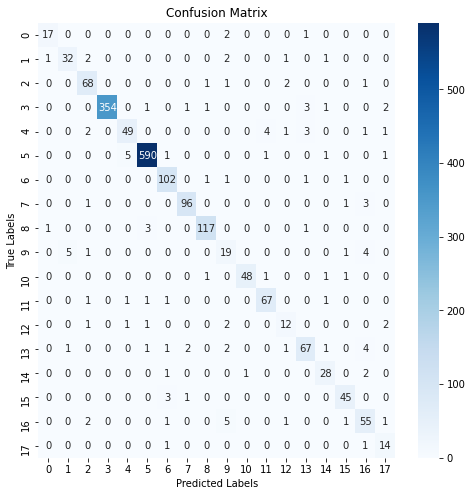

In [67]:
from sklearn.metrics import confusion_matrix

test_losses = []
y_pred = []
y_true = []

num_correct = 0

h = net.init_hidden(batch_size) # initialize hidden state

net.eval()

for inputs, labels in test_loader:

    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output, h = net(inputs, h) # model output
    
    test_loss = criterion(output.squeeze(), labels.long()) # test loss
    test_losses.append(test_loss.item())
    
    pred = torch.argmax(output.squeeze(), dim = 1)  # Predict the label

    y_pred.extend(pred.tolist())
    y_true.extend(labels.tolist())
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


print("Test loss: {:.3f}".format(np.mean(test_losses))) # average test loss

test_acc = num_correct/len(test_loader.dataset) # test data accuracy
print("Test accuracy: {:.3f}".format(test_acc))

print("\n\nConfusion matrix")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
None